In [65]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fiz_lernmodule.preprocessing import PreProcessor

import pickle
import re

# for clustering
from sklearn.cluster import *
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import pairwise_distances

from ipc_tools import read_ipc
ipc_dict = read_ipc('data/EN_ipc_title_list_20190101')

from utilities import *

In [66]:
seed_list = ['hair_dryer', 'video_codec', 'diesel', "contact_lens", "contact_lens_us_c", "3d_printer"]
src_dir = '.'
seeds = [seed_list[1]]
seed_name = seeds[0]

with open(src_dir + "/data/" + seed_name + "/clustered.pkl", 'rb') as infile:
    df = pickle.load(infile)

# Concept cluster

### Configuration variables

In [6]:
# Configuration variables

stem = False
remove_duplicates = False
min_ngram_length = 1
max_ngram_length = 2
max_sent_cluster_fraction = 0.3
filter_diversity = False
cluster_diversity = 0.33

In [7]:
def filter_text(text, join=True, return_joined=False, remove_duplicates=False, remove_short_long=True, stem=True):
    pre = PreProcessor()
    if join:
        filtered_text = pre.preprocess_text(' '.join(text), remove_short_long=remove_short_long, stem=stem)
    else:
        filtered_text = pre.preprocess_text(text, remove_short_long=remove_short_long, stem=stem)
    # index = []
    # next_pos = 0
    # for word in filtered_text:
    #     for idx in range(next_pos, len(text)):
    #         if word == text[idx]:
    #             index.append(idx)
    #             next_pos = idx + 1
    #             break

    if remove_duplicates:
        filtered_text = list(set(filtered_text))

    if return_joined:
        return [' '.join(filtered_text)]
    else:
        return filtered_text

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, max_df=1.0, norm='l2', ngram_range=(min_ngram_length, max_ngram_length))

all_filtered_documents = df['abstract_text'].apply(lambda x: filter_text(x, join=False, return_joined=True, stem=stem, remove_duplicates=remove_duplicates)).apply(lambda x: x[0]).to_list()

vectorizer.fit(all_filtered_documents)
features = np.array(vectorizer.get_feature_names())

def tfidf_on_document(doc, vectorizer, features, end=None):
    if type(doc) != list:
        doc = [doc]
    transformed = vectorizer.transform(doc)
    tfidf_sorting = np.argsort(transformed.toarray().flatten())[::-1] % features.shape[0]
    sorted_terms = features[tfidf_sorting]
    return sorted_terms[:end]

## helper functions

In [8]:
def generate_ngrams(words_list, n=max_ngram_length):
    "Helper function, mainly for extract_ipc_keywords"
    ngrams_list = []
 
    for num in range(0, len(words_list)):
        ngram = ' '.join(words_list[num:num + n])
        ngrams_list.append(ngram)
 
    return ngrams_list

def parenthesis_remover(text_string):
    return re.sub(r'\([^)]*\)', '', text_string)

def symbol_remover(text_string):
    text_string = re.sub(r'[,|.|;]', '', text_string)
    text_string = re.sub('[ |\n]+', ' ', text_string)
    return text_string

def plot_ipc_dist(df, threshold=0.0, reduce_hierarchy=False, sort=False):
    codes, frequency = get_common_ipc(df, threshold=threshold, reduce_hierarchy=reduce_hierarchy, sort=sort)
    fig = plt.figure(figsize=(25,6))
    ax = fig.gca()
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    sns.barplot(x=codes, y=frequency)
    plt.show()

def get_common_ipc(df, threshold=0.33, reduce_hierarchy=False, sort=True):
    if not reduce_hierarchy:
        ipc_classes = [y for x in df['ipc_classes'] for y in x]
    else:
        ipc_classes = [y for x in df['before_slash'] for y in x]
        ipc_classes = list(map(lambda x: x + '/00', ipc_classes))
    codes, frequency = np.unique(ipc_classes, return_counts=True)
    if sort:
        ranking = np.argsort(frequency)[::-1]
        codes, frequency = codes[ranking], frequency[ranking]
    mask = frequency/len(df) > threshold
    return codes[mask], np.round(frequency[mask]/len(df), 2)

def get_common_ipc_descriptions(df, threshold=0.33, reduce_hierarchy=False, remove_parenthesis=True, remove_symbols=True):
    ipc_codes, _ = get_common_ipc(df, threshold=threshold, reduce_hierarchy=reduce_hierarchy)
    ipc_descriptions = []
    for code in ipc_codes:
        if code in list(ipc_dict.keys()):
            ipc_descriptions.append(ipc_dict[code])
    if remove_parenthesis:
        ipc_descriptions = list(map(parenthesis_remover, ipc_descriptions))
    if remove_symbols:
        ipc_descriptions = list(map(symbol_remover, ipc_descriptions))
    return ipc_descriptions

def print_common_ipc(df, threshold=0.33, reduce_hierarchy=False):
    codes, frequency = get_common_ipc(df, threshold, reduce_hierarchy)
    for code, fraction in zip(codes, frequency):
        try:
            print(f'{code}, {fraction}:\t', ipc_dict[code])
        except:
            print(f'!No entry for {code}, {fraction}!')

In [9]:
# Sentence clustering happens here

grouped = df.groupby('cluster')
decoded_sentences_from_all_document_clusters = []
doc_idxs_from_all_doc_clusters = []
for cluster_idx in np.unique(df['cluster']):
    selected_group = grouped.get_group(cluster_idx)
    all_sentence_embeddings = np.concatenate(selected_group['sentence_embeddings'].tolist())
    all_decoded_sentences = [y for x in selected_group['decoded_sentences'] for y in x] # debug len 52
    
    lengths = selected_group['decoded_sentences'].apply(len)
    document_idxs = np.zeros(lengths.cumsum().iloc[-1], dtype=np.int64)
    past = 0
    for idx, amount in lengths.iteritems():
        document_idxs[past:(past+amount)] = idx
        past += amount

    cluster = cak(all_sentence_embeddings)
    unique, count = np.unique(cluster.labels_, return_counts=True)
    print(np.round(np.sort(count)[::-1]/len(all_sentence_embeddings), 2))
    print(np.round(np.cumsum(np.sort(count)[::-1]/len(all_sentence_embeddings)), 2))
    print(120*'-')
    num_dominant_clusters = np.where(np.cumsum(np.sort(count)[::-1]/len(all_sentence_embeddings)) >= max_sent_cluster_fraction)[0][0] + 1  # amount of clusters which acumulate to at least 50%
    dominant_clusters = unique[np.argsort(count)[::-1][:num_dominant_clusters]]
    
    decoded_sentences_of_document_cluster = []
    doc_idx_of_sentences_of_doc_cluster = []
    for cluster_idx, cluster_center in zip(dominant_clusters, cluster.cluster_centers_[dominant_clusters]):
        idx_of_sentences = np.where(cluster.labels_ == cluster_idx)[0]
        sentences_of_cluster = all_sentence_embeddings[idx_of_sentences]
        nearest_sentences = np.argsort(pairwise_distances(cluster_center.reshape(1, -1), sentences_of_cluster))[0]#[:5] #can limit the amount of sentences of a sentence cluster
        nearest_sentences = idx_of_sentences[nearest_sentences]
        decoded_sentences_of_sentence_cluster = []
        for i in nearest_sentences:
            decoded_sentences_of_sentence_cluster.append(' '.join(filter_text(all_decoded_sentences[i], stem=stem)))
        decoded_sentences_of_document_cluster.append(list(set(decoded_sentences_of_sentence_cluster)))
        doc_idx_of_sentences_of_doc_cluster.append(document_idxs[nearest_sentences])
    if not decoded_sentences_of_document_cluster:
        print("It's empty!")
        break
    decoded_sentences_from_all_document_clusters.append(decoded_sentences_of_document_cluster)
    doc_idxs_from_all_doc_clusters.append(doc_idx_of_sentences_of_doc_cluster)
del all_sentence_embeddings, all_decoded_sentences, lengths, document_idxs, past, cluster, unique, count, num_dominant_clusters, dominant_clusters, nearest_sentences
del decoded_sentences_of_sentence_cluster, decoded_sentences_of_document_cluster, doc_idx_of_sentences_of_doc_cluster, sentences_of_cluster, selected_group, amount, idx

[0.18 0.15 0.15 0.12 0.11 0.07 0.05 0.05 0.04 0.03 0.03 0.03]
[0.18 0.32 0.47 0.59 0.7  0.77 0.82 0.88 0.92 0.95 0.97 1.  ]
------------------------------------------------------------------------------------------------------------------------
[0.24 0.24 0.17 0.1  0.09 0.05 0.03 0.02 0.02 0.02 0.02]
[0.24 0.48 0.66 0.76 0.84 0.9  0.93 0.95 0.97 0.98 1.  ]
------------------------------------------------------------------------------------------------------------------------
[0.22 0.12 0.1  0.1  0.09 0.07 0.07 0.06 0.06 0.04 0.01 0.01 0.01]
[0.22 0.34 0.45 0.55 0.64 0.72 0.79 0.85 0.91 0.96 0.97 0.99 1.  ]
------------------------------------------------------------------------------------------------------------------------
[0.14 0.11 0.11 0.09 0.06 0.05 0.04 0.04 0.04 0.03 0.03 0.03 0.03 0.03
 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.14 0.25 0.36 0.45 0.5  0.55 0.59 0.62 0.66 0.69 0.72 0.74 0.77 0.8
 0.83 0.84 0.86 0.88 0.9  0.92 0.94 0.94 0.95 0.96 0

In [10]:
import pickle

# with open('data/saved_variables/decoded_sentences_from_all_document_clusters.pkl', 'wb') as f:
#     pickle.dump(decoded_sentences_from_all_document_clusters, f)
# with open('data/saved_variables/doc_idxs_from_all_doc_clusters.pkl', 'wb') as f:
#     pickle.dump(doc_idxs_from_all_doc_clusters, f)

with open('data/saved_variables/decoded_sentences_from_all_document_clusters.pkl', 'rb') as f:
    decoded_sentences_from_all_document_clusters = pickle.load(f)
with open('data/saved_variables/doc_idxs_from_all_doc_clusters.pkl', 'rb') as f:
    doc_idxs_from_all_doc_clusters = pickle.load(f)

## Filter sentence cluster in document cluster which diversity is less than 0cluster_diversity. If no sentence cluster is left, the one with highest diversity is chosen.

In [11]:
# Filter sentence cluster in document cluster which diversity is less than 0.33. If no sentence cluster is left, the one with highest diversity is chosen.

def calc_diversity(array):
    return np.unique(array).shape[0]/array.shape[0]

if filter_diversity:
    new_decoded_sentences_from_all_document_clusters = []
    new_doc_idxs_from_all_doc_clusters = []
    for idx, cluster in enumerate(doc_idxs_from_all_doc_clusters):
        diversity = list(map(calc_diversity, cluster))
        print(diversity)
        target = [i for i, val in enumerate(diversity) if val > cluster_diversity]
        if target:
            decoded_sentences_of_document_cluster = [decoded_sentences_from_all_document_clusters[idx][x] for x in target]
            doc_idx_of_sentences_of_doc_cluster = [doc_idxs_from_all_doc_clusters[idx][x] for x in target]
            pass
        else:
            decoded_sentences_of_document_cluster = [decoded_sentences_from_all_document_clusters[idx][np.argmax(diversity)]]
            doc_idx_of_sentences_of_doc_cluster = [doc_idxs_from_all_doc_clusters[idx][np.argmax(diversity)]]
        new_decoded_sentences_from_all_document_clusters.append(decoded_sentences_of_document_cluster)
        new_doc_idxs_from_all_doc_clusters.append(doc_idx_of_sentences_of_doc_cluster)
    del decoded_sentences_of_document_cluster, doc_idx_of_sentences_of_doc_cluster, target, diversity, idx, cluster

    decoded_sentences_from_all_document_clusters = new_decoded_sentences_from_all_document_clusters
    doc_idxs_from_all_doc_clusters = new_doc_idxs_from_all_doc_clusters

## New vectorizer which has been fitted on all sentences from all dominant sentence clusters from all document clusters

In [12]:
vectorizer = vectorizer.fit(sorted([' '.join(z) for y in decoded_sentences_from_all_document_clusters for z in y])) # treat sentences of sentence cluster as one document
features = np.array(vectorizer.get_feature_names())

# Keyword extraction of sentence clusters

In [13]:
def filter_redundant_words(output, allow_n_grams=True, new_output_size=20, init_filter_list=None, limit_input=200):
    new_output = []
    for extract in output[:limit_input]:
        if isinstance(init_filter_list, list) and init_filter_list:
            filter_list = ' '.join(init_filter_list.copy()).split(' ')
        else:
            filter_list = []
        for extract2 in new_output:
            filter_list.extend(extract2.split(' '))
        skip = False
        if allow_n_grams:
            splitted_extract = extract.split(' ')     # allows single words from n-gram if new
        for word in extract.split(' '):
            if word in filter_list:
                skip = True
                if allow_n_grams:
                    splitted_extract.remove(word)     # allows single words from n-gram if new
        if not skip:
            new_output.append(extract)
        elif allow_n_grams:                                     # allows single words from n-gram if new
            new_output.extend(splitted_extract)   # allows single words from n-gram if new
    return new_output[:new_output_size]

def calc_share(doc_cluster):
    share = np.empty(len(doc_cluster))
    sentence_amount = len(flatten(doc_cluster))
    for i in range(len(doc_cluster)):
        share[i] = len(doc_cluster[i])/sentence_amount
    return np.round(share, 1)

# Extract keywords from sentence cluster of a document cluster
def extract_keywords(doc_cluster, kw_amount=20):
    share = calc_share(doc_cluster)
    keywords = []
    for i, cluster in enumerate(doc_cluster):
        output = filter_redundant_words(list(tfidf_on_document(cluster, vectorizer=vectorizer, features=features)), new_output_size=kw_amount, init_filter_list=keywords)
        keywords.extend(output[:int(share[i]*kw_amount)])
    return keywords

def extract_ipc_keywords(df, max_ngram_length=max_ngram_length, threshold=0.33, reduce_hierarchy=False, remove_parenthesis=True, remove_symbols=True):
    "For evaluation purpose."
    descriptions = get_common_ipc_descriptions(df, threshold=threshold, reduce_hierarchy=False, remove_parenthesis=remove_parenthesis, remove_symbols=remove_symbols)
    descriptions = ' '.join(descriptions)
    keywords = descriptions.split(' ')

    if max_ngram_length > 1:
        for i in range(2, max_ngram_length+1):
            keywords.extend(generate_ngrams(descriptions.split(' '), i))

    return sorted(list(set(keywords)))

## Keyword extraction and evaluation for all clusters

In [18]:
# Remove redundant words from keywords

cluster_keywords = []
cluster_keywords_tfidf = []
cluster_keywords_tfidf_sw = []
cluster_keywords_ipc = []
for i, cluster in enumerate(decoded_sentences_from_all_document_clusters):
    keywords = (extract_keywords(cluster))
    selected_group = grouped.get_group(i)
    all_decoded_sentences_sw = flatten(cluster)
    keywords_tfidf = filter_redundant_words(list(tfidf_on_document(all_decoded_sentences_sw, vectorizer, features)))[:20]
    keywords_ipc = extract_ipc_keywords(selected_group, reduce_hierarchy=False, threshold=0.2)
    cluster_keywords.append(keywords)
    cluster_keywords_tfidf.append(keywords_tfidf)
    cluster_keywords_ipc.append(keywords_ipc)
    
unique_keywords = []
for i in range(len(decoded_sentences_from_all_document_clusters)):
    print('Cluster:', i, '\n')
    temp_keywords = cluster_keywords.copy()
    del temp_keywords[i]
    unique_keywords.append(complement(cluster_keywords[i], flatten(temp_keywords)))
    print('Unique keywords among all document clusters:', unique_keywords[-1])
    print('Extracted keywords:', cluster_keywords[i])
    print('TF-IDF keywords:', cluster_keywords_tfidf[i])
    print('IPC words:', cluster_keywords_ipc[i])
    print(60*'-')
    print('Intersection between concept and TF-IDF:', intersection(cluster_keywords[i], cluster_keywords_tfidf[i]))
    print('Complement of extracted keywords:', complement(cluster_keywords[i], cluster_keywords_tfidf[i]))
    print('Complement of TF-IDF:', complement(cluster_keywords_tfidf[i], cluster_keywords[i]))
    print(60*'-')
    print('Intersection between concept and IPC:', intersection(cluster_keywords[i], cluster_keywords_ipc[i]))
    print('Complement of extracted keywords:', complement(cluster_keywords[i], cluster_keywords_ipc[i]))
    print('Complement of IPC:', complement(cluster_keywords_ipc[i], cluster_keywords[i]))
    print(60*'-')
    print('Percentual share of concept and TF-IDF:', precision(cluster_keywords[i], cluster_keywords_tfidf[i]))
    print('Percentual share of concept and IPC:', precision(cluster_keywords[i], cluster_keywords_ipc[i]))
    print('Percentual share of unique keywords:', np.round(len(unique_keywords[-1])/len(cluster_keywords[i]), 2))
    print('\n' + 240*'-')

Cluster: 0 

Unique keywords among all document clusters: ['block type', 'collocated current', 'differential motion', 'vector encoder', 'pmv', 'provided encoding', 'vectors', 'ordered', 'multiple reference', 'ordinary', 'prediction number', 'spatial', 'virtual', 'differences']
Extracted keywords: ['block type', 'collocated current', 'differential motion', 'vector encoder', 'predictor', 'pmv', 'signal', 'provided encoding', 'vectors', 'image', 'ordered', 'multiple reference', 'ordinary', 'information', 'prediction number', 'encoded', 'temporal', 'spatial', 'virtual', 'differences']
TF-IDF keywords: ['block type', 'motion image', 'ordered', 'vector', 'collocated current', 'encoder', 'differential', 'predictor', 'multiple reference', 'ordinary', 'pmv', 'information', 'vectors', 'candidate', 'signal', 'provided encoding', 'prediction number', 'encoded', 'optimum', 'temporal']
IPC words: ['', ' Motion', 'Embedding', 'Embedding additional', 'Motion', 'Motion compensation', 'Motion estimation

# Check IPC codes / Reference

In [19]:
doc_cluster_idx = 0
sent_cluster_idx = 0

sentence_cluster = df.loc[doc_idxs_from_all_doc_clusters[doc_cluster_idx][sent_cluster_idx]]
document_cluster = df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])]

In [20]:
document_cluster = df.loc[np.hstack(doc_idxs_from_all_doc_clusters[0])]
print_common_ipc(document_cluster, threshold=0.1, reduce_hierarchy=True)

H04N19/00, 1.0:	 Methods or arrangements for coding, decoding, compressing or decompressing digital video signals
H04N7/00, 0.54:	 Television systems (details H04N3/00, H04N3/00;methods or arrangements, for coding, decoding, compressing or decompressing digital video signals H04N3/00;selective content distribution H04N3/00)
H04N11/00, 0.21:	 Colour television systems (details H04N9/00)
H04B1/00, 0.12:	 Details of transmission systems, not covered by a single one of groups H04B3/00-H04B3/00; Details of transmission systems not characterised by the medium used for transmission
H03M7/00, 0.12:	 Conversion of a code where information is represented by a given sequence or number of digits to a code where the same information is represented by a different sequence or number of digits


In [21]:
document_cluster = df.loc[np.hstack(doc_idxs_from_all_doc_clusters[-1])]
print_common_ipc(document_cluster, threshold=0.1, reduce_hierarchy=True)

H04N19/00, 0.72:	 Methods or arrangements for coding, decoding, compressing or decompressing digital video signals
H04N7/00, 0.64:	 Television systems (details H04N3/00, H04N3/00;methods or arrangements, for coding, decoding, compressing or decompressing digital video signals H04N3/00;selective content distribution H04N3/00)
H03M7/00, 0.48:	 Conversion of a code where information is represented by a given sequence or number of digits to a code where the same information is represented by a different sequence or number of digits
G06T9/00, 0.36:	 Image coding (bandwidth or redundancy reduction for static pictures H04N1/41;coding or decoding of static colour picture signals H04N1/41;methods or arrangements for coding, decoding, compressing or decompressing digital video signals H04N1/41)
G06K9/00, 0.28:	 Methods or arrangements for reading or recognising printed or written characters or for recognising patterns, e.g. fingerprints (methods or arrangements for graph-reading or for convertin

In [22]:
document_cluster = df.loc[np.hstack(doc_idxs_from_all_doc_clusters[3])]
print_common_ipc(document_cluster, threshold=0.1, reduce_hierarchy=True)

H04N19/00, 0.79:	 Methods or arrangements for coding, decoding, compressing or decompressing digital video signals
H04N7/00, 0.64:	 Television systems (details H04N3/00, H04N3/00;methods or arrangements, for coding, decoding, compressing or decompressing digital video signals H04N3/00;selective content distribution H04N3/00)
G06T9/00, 0.59:	 Image coding (bandwidth or redundancy reduction for static pictures H04N1/41;coding or decoding of static colour picture signals H04N1/41;methods or arrangements for coding, decoding, compressing or decompressing digital video signals H04N1/41)
H03M7/00, 0.38:	 Conversion of a code where information is represented by a given sequence or number of digits to a code where the same information is represented by a different sequence or number of digits
G06K9/00, 0.23:	 Methods or arrangements for reading or recognising printed or written characters or for recognising patterns, e.g. fingerprints (methods or arrangements for graph-reading or for convertin

In [23]:
document_cluster = df.loc[np.hstack(doc_idxs_from_all_doc_clusters[4])]
print_common_ipc(document_cluster, threshold=0.1, reduce_hierarchy=True)

H04N7/00, 0.84:	 Television systems (details H04N3/00, H04N3/00;methods or arrangements, for coding, decoding, compressing or decompressing digital video signals H04N3/00;selective content distribution H04N3/00)
G06T9/00, 0.5:	 Image coding (bandwidth or redundancy reduction for static pictures H04N1/41;coding or decoding of static colour picture signals H04N1/41;methods or arrangements for coding, decoding, compressing or decompressing digital video signals H04N1/41)
H04N19/00, 0.45:	 Methods or arrangements for coding, decoding, compressing or decompressing digital video signals
H03M7/00, 0.42:	 Conversion of a code where information is represented by a given sequence or number of digits to a code where the same information is represented by a different sequence or number of digits
H04N1/00, 0.29:	 Scanning, transmission or reproduction of documents or the like, e.g. facsimile transmission; Details thereof
H04B1/00, 0.26:	 Details of transmission systems, not covered by a single one 

In [24]:
document_cluster = df.loc[np.hstack(doc_idxs_from_all_doc_clusters[5])]
print_common_ipc(document_cluster, threshold=0.1, reduce_hierarchy=True)

H04N19/00, 0.88:	 Methods or arrangements for coding, decoding, compressing or decompressing digital video signals
H04N7/00, 0.21:	 Television systems (details H04N3/00, H04N3/00;methods or arrangements, for coding, decoding, compressing or decompressing digital video signals H04N3/00;selective content distribution H04N3/00)
G06T9/00, 0.21:	 Image coding (bandwidth or redundancy reduction for static pictures H04N1/41;coding or decoding of static colour picture signals H04N1/41;methods or arrangements for coding, decoding, compressing or decompressing digital video signals H04N1/41)
G06K9/00, 0.12:	 Methods or arrangements for reading or recognising printed or written characters or for recognising patterns, e.g. fingerprints (methods or arrangements for graph-reading or for converting the pattern of mechanical parameters, e.g. force or presence, into electrical signals G06K11/00;speech recognition G06K11/00)


In [25]:
document_cluster = df.loc[np.hstack(doc_idxs_from_all_doc_clusters[6])]
print_common_ipc(document_cluster, threshold=0.1, reduce_hierarchy=True)

H04N7/00, 0.68:	 Television systems (details H04N3/00, H04N3/00;methods or arrangements, for coding, decoding, compressing or decompressing digital video signals H04N3/00;selective content distribution H04N3/00)
H04N19/00, 0.68:	 Methods or arrangements for coding, decoding, compressing or decompressing digital video signals
G06T9/00, 0.39:	 Image coding (bandwidth or redundancy reduction for static pictures H04N1/41;coding or decoding of static colour picture signals H04N1/41;methods or arrangements for coding, decoding, compressing or decompressing digital video signals H04N1/41)
H03M7/00, 0.36:	 Conversion of a code where information is represented by a given sequence or number of digits to a code where the same information is represented by a different sequence or number of digits
H04N11/00, 0.29:	 Colour television systems (details H04N9/00)
H04N9/00, 0.21:	 Details of colour television systems
H04N21/00, 0.21:	 Selective content distribution, e.g. interactive television or video 

In [26]:
print_common_ipc(sentence_cluster, threshold=0.33)

H04N19/52, 0.62:	 by predictive encoding
H04N7/12, 0.54:	 Systems in which the television signal is transmitted via one channel or a plurality of parallel channels, the bandwidth of each channel being less than the bandwidth of the television signal (H04N7/24 takes precedence)
H04N19/61, 0.54:	 in combination with predictive coding
H04N19/51, 0.54:	 Motion estimation or motion compensation
H04N19/176, 0.38:	 the region being a block, e.g. a macroblock


In [27]:
print_common_ipc(document_cluster, threshold=0.33)

H04N19/136, 0.54:	 Incoming video signal characteristics or properties
H04N19/61, 0.5:	 in combination with predictive coding
H04N19/51, 0.43:	 Motion estimation or motion compensation
H04N19/503, 0.43:	 involving temporal prediction (adaptive coding with adaptive selection between spatial and temporal predictive coding H04N19/107;adaptive coding with adaptive selection among a plurality of temporal predictive coding modes H04N19/107)
H04N19/176, 0.39:	 the region being a block, e.g. a macroblock
H04N7/12, 0.39:	 Systems in which the television signal is transmitted via one channel or a plurality of parallel channels, the bandwidth of each channel being less than the bandwidth of the television signal (H04N7/24 takes precedence)
G06T9/00, 0.39:	 Image coding (bandwidth or redundancy reduction for static pictures H04N1/41;coding or decoding of static colour picture signals H04N1/41;methods or arrangements for coding, decoding, compressing or decompressing digital video signals H04N1/41)

## IPC distribution

<ipython-input-8-132313c9d6f4>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


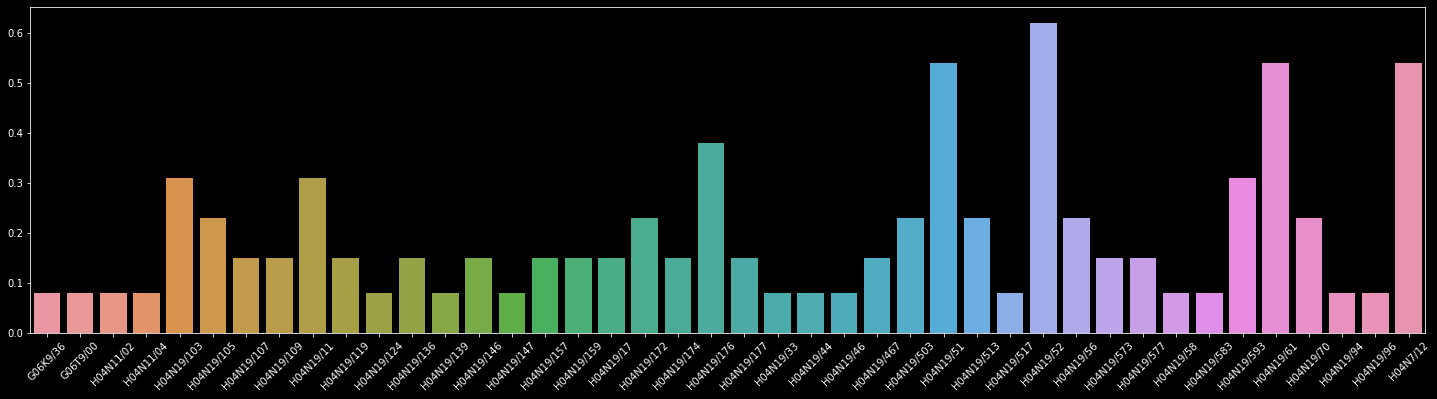

In [28]:
plot_ipc_dist(df.loc[doc_idxs_from_all_doc_clusters[0][0]], threshold=0.0, sort=False)

<ipython-input-8-132313c9d6f4>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


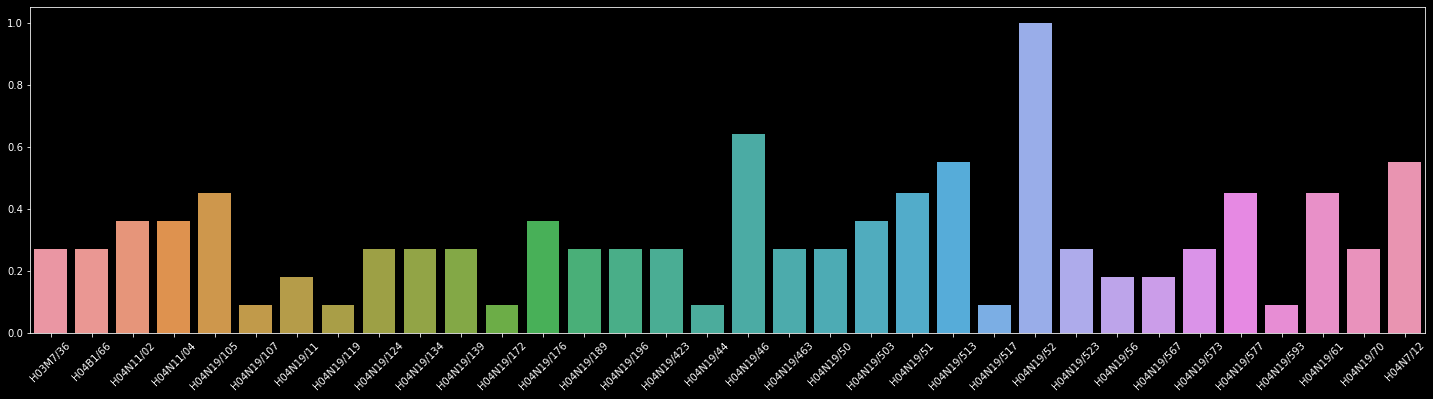

In [29]:
plot_ipc_dist(df.loc[doc_idxs_from_all_doc_clusters[0][1]],threshold=0.0, sort=False)

<ipython-input-8-132313c9d6f4>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


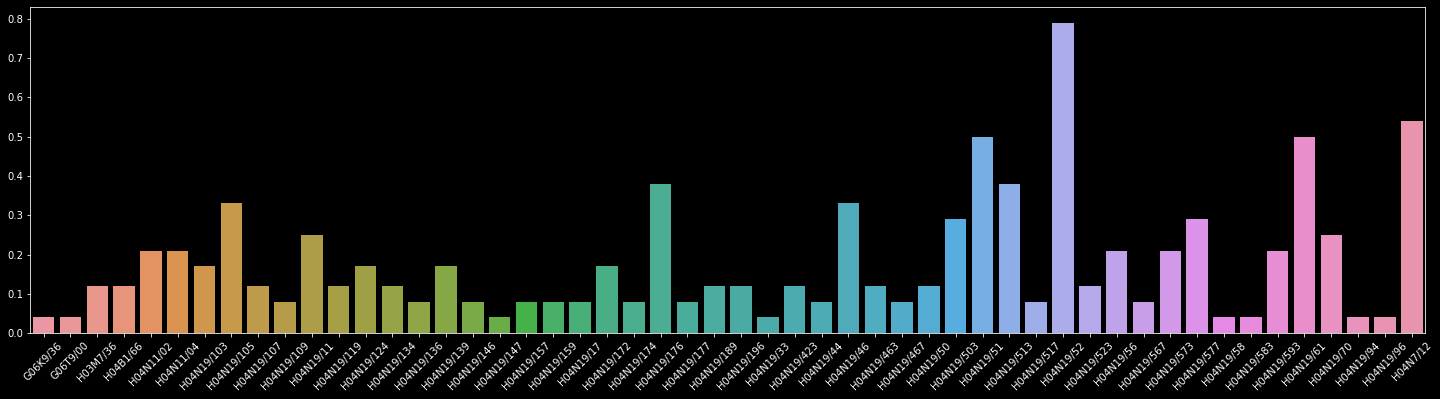

In [30]:
plot_ipc_dist(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)

<ipython-input-8-132313c9d6f4>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


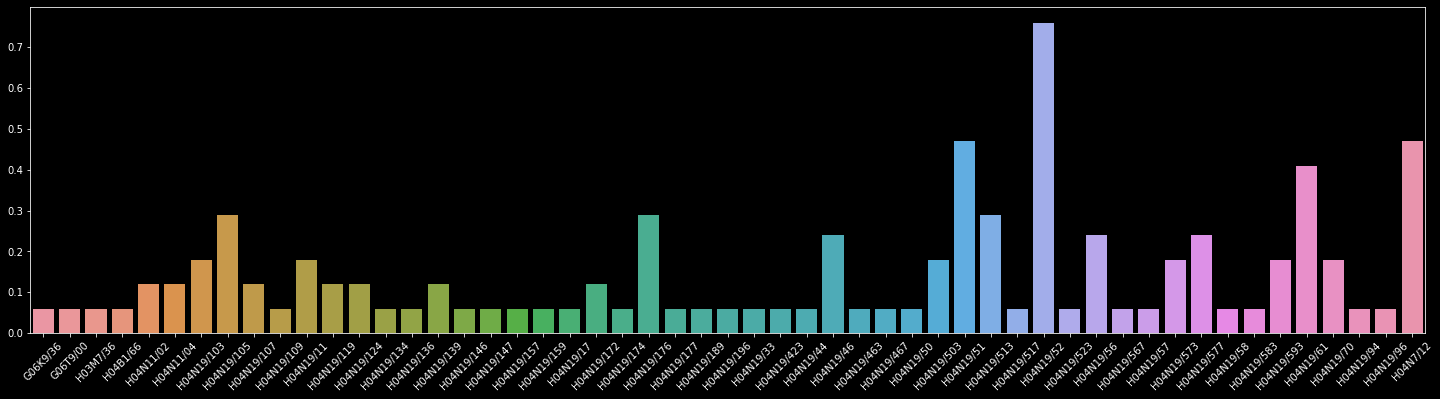

In [31]:
plot_ipc_dist(grouped.get_group(0), threshold=0.0, sort=False)

In [32]:
get_common_ipc(df.loc[doc_idxs_from_all_doc_clusters[0][0]], threshold=0.0, sort=False)

(array(['G06K9/36', 'G06T9/00', 'H04N11/02', 'H04N11/04', 'H04N19/103',
        'H04N19/105', 'H04N19/107', 'H04N19/109', 'H04N19/11',
        'H04N19/119', 'H04N19/124', 'H04N19/136', 'H04N19/139',
        'H04N19/146', 'H04N19/147', 'H04N19/157', 'H04N19/159',
        'H04N19/17', 'H04N19/172', 'H04N19/174', 'H04N19/176',
        'H04N19/177', 'H04N19/33', 'H04N19/44', 'H04N19/46', 'H04N19/467',
        'H04N19/503', 'H04N19/51', 'H04N19/513', 'H04N19/517', 'H04N19/52',
        'H04N19/56', 'H04N19/573', 'H04N19/577', 'H04N19/58', 'H04N19/583',
        'H04N19/593', 'H04N19/61', 'H04N19/70', 'H04N19/94', 'H04N19/96',
        'H04N7/12'], dtype='<U10'),
 array([0.08, 0.08, 0.08, 0.08, 0.31, 0.23, 0.15, 0.15, 0.31, 0.15, 0.08,
        0.15, 0.08, 0.15, 0.08, 0.15, 0.15, 0.15, 0.23, 0.15, 0.38, 0.15,
        0.08, 0.08, 0.08, 0.15, 0.23, 0.54, 0.23, 0.08, 0.62, 0.23, 0.15,
        0.15, 0.08, 0.08, 0.31, 0.54, 0.23, 0.08, 0.08, 0.54]))

In [33]:
get_common_ipc(df.loc[doc_idxs_from_all_doc_clusters[0][1]],threshold=0.0, sort=False)

(array(['H03M7/36', 'H04B1/66', 'H04N11/02', 'H04N11/04', 'H04N19/105',
        'H04N19/107', 'H04N19/11', 'H04N19/119', 'H04N19/124',
        'H04N19/134', 'H04N19/139', 'H04N19/172', 'H04N19/176',
        'H04N19/189', 'H04N19/196', 'H04N19/423', 'H04N19/44', 'H04N19/46',
        'H04N19/463', 'H04N19/50', 'H04N19/503', 'H04N19/51', 'H04N19/513',
        'H04N19/517', 'H04N19/52', 'H04N19/523', 'H04N19/56', 'H04N19/567',
        'H04N19/573', 'H04N19/577', 'H04N19/593', 'H04N19/61', 'H04N19/70',
        'H04N7/12'], dtype='<U10'),
 array([0.27, 0.27, 0.36, 0.36, 0.45, 0.09, 0.18, 0.09, 0.27, 0.27, 0.27,
        0.09, 0.36, 0.27, 0.27, 0.27, 0.09, 0.64, 0.27, 0.27, 0.36, 0.45,
        0.55, 0.09, 1.  , 0.27, 0.18, 0.18, 0.27, 0.45, 0.09, 0.45, 0.27,
        0.55]))

In [34]:
get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[0]

array(['G06K9/36', 'G06T9/00', 'H03M7/36', 'H04B1/66', 'H04N11/02',
       'H04N11/04', 'H04N19/103', 'H04N19/105', 'H04N19/107',
       'H04N19/109', 'H04N19/11', 'H04N19/119', 'H04N19/124',
       'H04N19/134', 'H04N19/136', 'H04N19/139', 'H04N19/146',
       'H04N19/147', 'H04N19/157', 'H04N19/159', 'H04N19/17',
       'H04N19/172', 'H04N19/174', 'H04N19/176', 'H04N19/177',
       'H04N19/189', 'H04N19/196', 'H04N19/33', 'H04N19/423', 'H04N19/44',
       'H04N19/46', 'H04N19/463', 'H04N19/467', 'H04N19/50', 'H04N19/503',
       'H04N19/51', 'H04N19/513', 'H04N19/517', 'H04N19/52', 'H04N19/523',
       'H04N19/56', 'H04N19/567', 'H04N19/573', 'H04N19/577', 'H04N19/58',
       'H04N19/583', 'H04N19/593', 'H04N19/61', 'H04N19/70', 'H04N19/94',
       'H04N19/96', 'H04N7/12'], dtype='<U10')

In [35]:
get_common_ipc(grouped.get_group(0), threshold=0.0, sort=False)[0]

array(['G06K9/36', 'G06T9/00', 'H03M7/36', 'H04B1/66', 'H04N11/02',
       'H04N11/04', 'H04N19/103', 'H04N19/105', 'H04N19/107',
       'H04N19/109', 'H04N19/11', 'H04N19/119', 'H04N19/124',
       'H04N19/134', 'H04N19/136', 'H04N19/139', 'H04N19/146',
       'H04N19/147', 'H04N19/157', 'H04N19/159', 'H04N19/17',
       'H04N19/172', 'H04N19/174', 'H04N19/176', 'H04N19/177',
       'H04N19/189', 'H04N19/196', 'H04N19/33', 'H04N19/423', 'H04N19/44',
       'H04N19/46', 'H04N19/463', 'H04N19/467', 'H04N19/50', 'H04N19/503',
       'H04N19/51', 'H04N19/513', 'H04N19/517', 'H04N19/52', 'H04N19/523',
       'H04N19/56', 'H04N19/567', 'H04N19/57', 'H04N19/573', 'H04N19/577',
       'H04N19/58', 'H04N19/583', 'H04N19/593', 'H04N19/61', 'H04N19/70',
       'H04N19/94', 'H04N19/96', 'H04N7/12'], dtype='<U10')

### Comparison of IPC codes for document cluster 1, before and after sentence filtration

In [36]:
complement(get_common_ipc(grouped.get_group(0), threshold=0.0, sort=False)[0].tolist(), get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[0].tolist())

['H04N19/57']

In [37]:
[i for i, val in enumerate(get_common_ipc(grouped.get_group(0), threshold=0.0, sort=False)[0].tolist()) if val == 'H04N19/57']

[42]

In [38]:
codes = get_common_ipc(grouped.get_group(0), threshold=0.0, sort=False)[0].tolist()
share = get_common_ipc(grouped.get_group(0), threshold=0.0, sort=False)[1].tolist()
del codes[42], share[42]

In [39]:
(np.array(share) - np.array(get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[1].tolist()))

array([ 0.02,  0.02, -0.06, -0.06, -0.09, -0.09,  0.01, -0.04,  0.  ,
       -0.02, -0.07,  0.  , -0.05, -0.06, -0.02, -0.05, -0.02,  0.02,
       -0.02, -0.02, -0.02, -0.05, -0.02, -0.09, -0.02, -0.06, -0.06,
        0.02, -0.06, -0.02, -0.09, -0.06, -0.02, -0.06, -0.11, -0.03,
       -0.09, -0.02, -0.03, -0.06,  0.03, -0.02, -0.03, -0.05,  0.02,
        0.02, -0.03, -0.09, -0.07,  0.02,  0.02, -0.07])

In [40]:
np.round(np.mean(np.sort(np.array(share) - np.array(get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[1].tolist()))), 3)

-0.035

In [41]:
np.round(np.std(np.sort(np.array(share) - np.array(get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[1].tolist()))), 3)

0.037

### Comparison of document cluster 01 with its first sentence cluster

In [42]:
removed_codes = complement(get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[0].tolist(), get_common_ipc(df.loc[doc_idxs_from_all_doc_clusters[0][0]], threshold=0.0, sort=False)[0].tolist()) 
to_remove = [i for i, val in enumerate(get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[0].tolist()) if val in removed_codes][::-1]
codes = get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[0].tolist()
share = get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[1].tolist()
for i in to_remove:
    del codes[i], share[i]

In [43]:
removed_codes

['H03M7/36',
 'H04B1/66',
 'H04N19/134',
 'H04N19/189',
 'H04N19/196',
 'H04N19/423',
 'H04N19/463',
 'H04N19/50',
 'H04N19/523',
 'H04N19/567']

In [44]:
differences = np.array(share) - get_common_ipc(df.loc[doc_idxs_from_all_doc_clusters[0][0]], threshold=0.0, sort=False)[1]
differences

array([-0.04, -0.04,  0.13,  0.13, -0.14,  0.1 , -0.03, -0.07, -0.06,
       -0.03,  0.09, -0.07,  0.09, -0.07, -0.04, -0.07, -0.07, -0.07,
       -0.06, -0.07,  0.  , -0.07, -0.04,  0.  ,  0.25, -0.07,  0.06,
       -0.04,  0.15,  0.  ,  0.17, -0.02,  0.06,  0.14, -0.04, -0.04,
       -0.1 , -0.04,  0.02, -0.04, -0.04,  0.  ])

In [45]:
np.sort(differences)

array([-0.14, -0.1 , -0.07, -0.07, -0.07, -0.07, -0.07, -0.07, -0.07,
       -0.07, -0.07, -0.06, -0.06, -0.04, -0.04, -0.04, -0.04, -0.04,
       -0.04, -0.04, -0.04, -0.04, -0.04, -0.03, -0.03, -0.02,  0.  ,
        0.  ,  0.  ,  0.  ,  0.02,  0.06,  0.06,  0.09,  0.09,  0.1 ,
        0.13,  0.13,  0.14,  0.15,  0.17,  0.25])

In [46]:
differences[np.abs(differences) > 0.1]

array([ 0.13,  0.13, -0.14,  0.25,  0.15,  0.17,  0.14])

In [47]:
[val for i, val in enumerate(codes) if (np.abs(differences) > 0.1)[i] == True]

['H04N11/02',
 'H04N11/04',
 'H04N19/103',
 'H04N19/46',
 'H04N19/513',
 'H04N19/52',
 'H04N19/577']

In [48]:
np.round(np.mean(differences), 3)

-0.002

In [49]:
np.round(np.std(differences), 3)

0.085

### Comparison of document cluster 01 with its second sentence cluster

In [50]:
removed_codes = complement(get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[0].tolist(), get_common_ipc(df.loc[doc_idxs_from_all_doc_clusters[0][1]], threshold=0.0, sort=False)[0].tolist()) 
to_remove = [i for i, val in enumerate(get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[0].tolist()) if val in removed_codes][::-1]
codes = get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[0].tolist()
share = get_common_ipc(df.loc[np.hstack(doc_idxs_from_all_doc_clusters[doc_cluster_idx])], threshold=0.0, sort=False)[1].tolist()
for i in to_remove:
    del codes[i], share[i]

In [51]:
len(removed_codes)

18

In [52]:
len(codes)

34

In [53]:
differences = np.array(share) - get_common_ipc(df.loc[doc_idxs_from_all_doc_clusters[0][1]], threshold=0.0, sort=False)[1]
differences

array([-0.15, -0.15, -0.15, -0.15, -0.12,  0.03,  0.07,  0.03, -0.1 ,
       -0.15, -0.1 ,  0.08,  0.02, -0.15, -0.15, -0.15, -0.01, -0.31,
       -0.15, -0.15, -0.07,  0.05, -0.17, -0.01, -0.21, -0.15,  0.03,
       -0.1 , -0.06, -0.16,  0.12,  0.05, -0.02, -0.01])

In [54]:
np.sort(differences)

array([-0.31, -0.21, -0.17, -0.16, -0.15, -0.15, -0.15, -0.15, -0.15,
       -0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0.12, -0.1 , -0.1 ,
       -0.1 , -0.07, -0.06, -0.02, -0.01, -0.01, -0.01,  0.02,  0.03,
        0.03,  0.03,  0.05,  0.05,  0.07,  0.08,  0.12])

In [55]:
differences[np.abs(differences) > 0.1]

array([-0.15, -0.15, -0.15, -0.15, -0.12, -0.15, -0.15, -0.15, -0.15,
       -0.31, -0.15, -0.15, -0.17, -0.21, -0.15, -0.16,  0.12])

In [56]:
[val for i, val in enumerate(codes) if (np.abs(differences) > 0.1)[i] == True]

['H03M7/36',
 'H04B1/66',
 'H04N11/02',
 'H04N11/04',
 'H04N19/105',
 'H04N19/134',
 'H04N19/189',
 'H04N19/196',
 'H04N19/423',
 'H04N19/46',
 'H04N19/463',
 'H04N19/50',
 'H04N19/513',
 'H04N19/52',
 'H04N19/523',
 'H04N19/577',
 'H04N19/593']

In [57]:
np.round(np.mean(differences), 3)

-0.077

In [58]:
np.round(np.std(differences), 3)

0.098